In [169]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from fiona.crs import from_epsg
import pulp
from sklearn import linear_model
import statsmodels.api as sm

%matplotlib inline

/Users/nnhoucheng/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data

In [21]:
man = pd.read_csv('manhattan_grids_final.csv', index_col=0)
man.rename(columns={'0': 'GRID_ID'}, inplace=True)

In [10]:
matrix = np.load('neighbour.npy')

In [3]:
df = gpd.GeoDataFrame.from_file('Manhattan/manhattan.shp')

In [140]:
hex_usage = pd.read_csv('hex_usage.csv', index_col=0)

In [145]:
df_man = gpd.GeoDataFrame(pd.merge(man, df, on='GRID_ID', how='left'))

df_man = df_man.merge(hex_usage, on='GRID_ID', how='left')
df_man.fillna(0, inplace=True)

# Regression

In [150]:
hu = hex_usage.merge(df, on='GRID_ID', how='left')

In [152]:
hu.columns

Index(['GRID_ID', 'time_usage', 'car_usage', 'Bangladesh', 'dropoff_co',
       'geometry', 'hotel', 'idle_count', 'idle_time_', 'parks', 'pickup_cou',
       'rest_cheap', 'rest_india', 'rs_count', 'violations'],
      dtype='object')

In [254]:
hu['ratio'] = hu.apply(lambda row: row['car_usage']/row["idle_count"], axis=1)
y_train = hu['ratio']
x_train = hu.loc[:,['dropoff_co', 'pickup_cou', 'hotel', 'parks', 'rest_cheap']]

In [255]:
for c in x_train.columns:
    lr = sm.OLS(y_train, sm.add_constant(x_train[c])).fit()
    print(c)
    print(lr.summary())
    print('\n')

dropoff_co
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     8.276
Date:                Wed, 26 Jul 2017   Prob (F-statistic):            0.00733
Time:                        04:48:14   Log-Likelihood:                 7.5574
No. Observations:                  32   AIC:                            -11.11
Df Residuals:                      30   BIC:                            -8.183
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4213      0.078      5.3

In [256]:
lr = sm.OLS(y_train, sm.add_constant(x_train.drop('parks', axis=1))).fit()

In [257]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     2.198
Date:                Wed, 26 Jul 2017   Prob (F-statistic):             0.0960
Time:                        04:48:22   Log-Likelihood:                 8.1699
No. Observations:                  32   AIC:                            -6.340
Df Residuals:                      27   BIC:                            0.9889
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6246      0.259      2.409      0.023       0.093       1.156
dropoff_co -5.376e-05      0.000     -0.356      0.725      -0.000       0.000
pickup_cou -2.589e-05      0.000     -0.209      0.836      -0.000       0.000
hotel          0.0013      0.003      0.489      0.629      -0.004       0.007
rest_cheap    -0.0052      0.006     -0.940      0.355      -0.017       0.006
==============================================================================
Omnibus:                       29.038   Durbin-Watson:                   2.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.854
Skew:                           2.026   Prob(JB):                     8.26e-15
Kurtosis:                       8.677   Cond. No.                     2.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

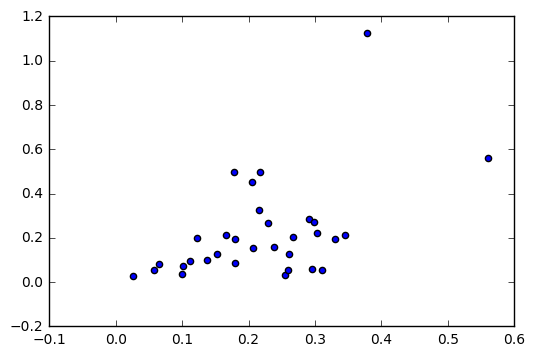

In [258]:
plt.scatter(lr.predict(sm.add_constant(x_train.drop('parks', axis=1))), y_train)

In [281]:
p = lr.predict(sm.add_constant(df_man.loc[:,['dropoff_co', 'pickup_cou', 'hotel', 'rest_cheap']]))

inl = hu.GRID_ID.apply(lambda n: np.where(df_man.GRID_ID == n)[0][0])

p[inl] = hu['ratio']

p[np.where(p < 0)[0]] = 0

In [282]:
p.mean()

0.4356955159555918

# LP

In [283]:
size = 423
R = 20
w0 = 0.8
w1 = 0.2
alpha = 10.

In [286]:
trs_model = pulp.LpProblem("trs Problem", pulp.LpMaximize)

### Independant Variables

x = pulp.LpVariable.dict('x_%s', range(size))
y = pulp.LpVariable.dict('y_%s', range(size), lowBound=0, upBound=1, cat="Binary")

### Object Function

c = df_man.apply(lambda row: (row['violations']+1)/(row["idle_count"]+1), axis=1)
trs_model += sum([c[i] * p[i] * x[i] for i in range(size)])

### Constraints

trs_model += sum([y[i] for i in range(size)]) <= R

for i in range(size):
    trs_model += x[i] <= df_man.loc[i, "idle_count"]/alpha
    trs_model += x[i] <= w0*y[i] + w1*sum([y[j] for j in np.where(matrix[i, :] == 1)[0]])

In [287]:
trs_model.solve()

1

In [288]:
ids = []
for v in trs_model.variables():
    if v.name.startswith("y") & (v.varValue == 1):
        ids.append(df_man.loc[int(v.name[2:]),'GRID_ID'])

In [289]:
ids

['BI-30',
 'BG-33',
 'BO-34',
 'BK-37',
 'BL-32',
 'BG-43',
 'BF-34',
 'BN-38',
 'AZ-54',
 'BM-33',
 'BH-41',
 'BG-40',
 'BG-41',
 'BI-40',
 'BN-34',
 'BC-37',
 'BH-31',
 'BF-33',
 'BH-44',
 'BB-51']

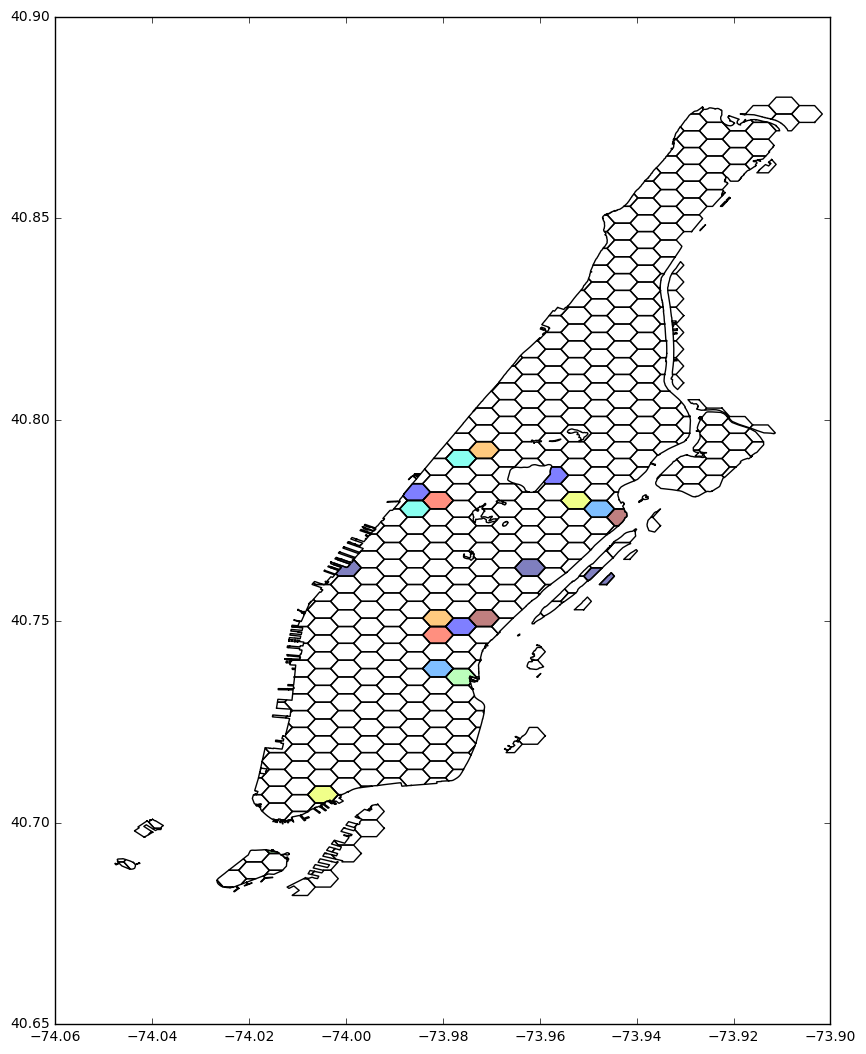

In [290]:
fig0, ax0 = plt.subplots(num=0, figsize=(10,13))
df_man.plot(ax=ax0, color='white')
df_man[df_man.GRID_ID.isin(ids)].plot(ax=ax0)